In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/Dataset/Loan Dataset.csv")
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [5]:
print("---Information:---")
print(df.info())
print("\n---Duplicate values:---")
print(df.duplicated().sum())
print("\n---NuN values:---")
print(df.isnull().sum())

---Information:---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None

---Duplicate values:---
0

---NuN values:---
Loan_ID               0
Gender            

In [6]:
df.fillna(df.mode().iloc[0], inplace=True)
df.isnull().sum()

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


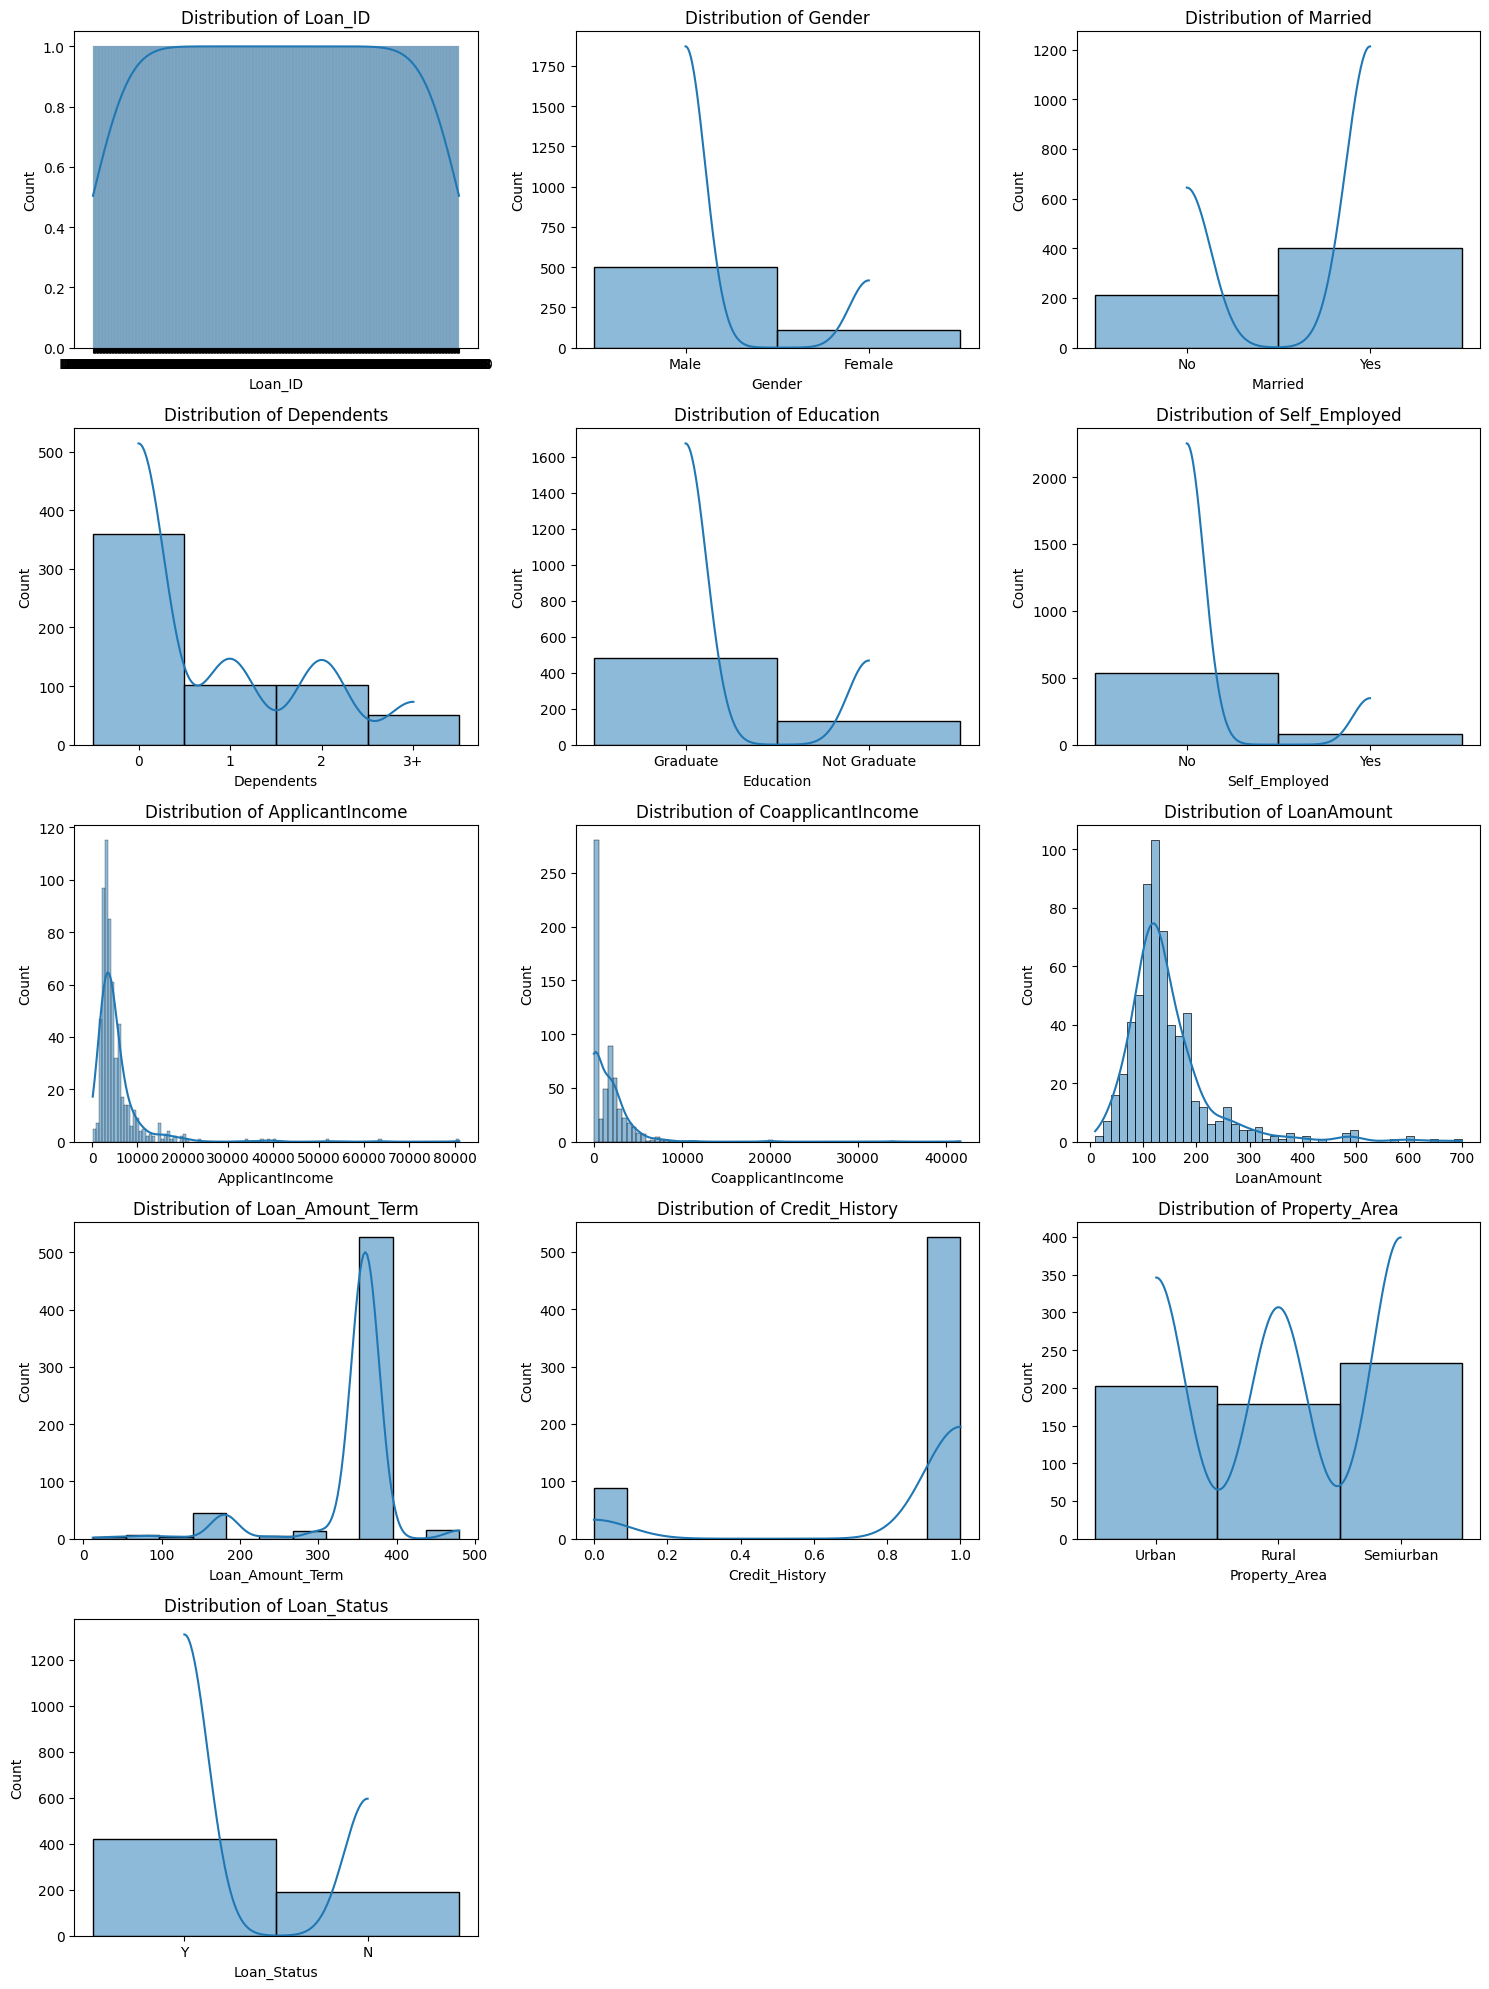

In [7]:
import math

# Number of charts per row
n_cols = 3

# Calculate required number of rows
n_rows = math.ceil(len(df.columns) / n_cols)

# Create subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# Plot each column on its subplot
for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].set_title(f"Distribution of {col}")

# Hide any unused axes (if columns not multiple of 3)
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [8]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

# Outlier Remove

In [9]:
numeric_cols = df[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']]

# Remove outliers using the IQR method
for col in numeric_cols:
    Q_1 = df[col].quantile(0.25)
    Q_3 = df[col].quantile(0.75)
    IQR = Q_3 - Q_1

    Lower_bound = Q_1 - (1.5 * IQR)
    Upper_bound = Q_3 + (1.5 * IQR)

    df = df[(df[col] >= Lower_bound) & (df[col] <= Upper_bound)]

df.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,120.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


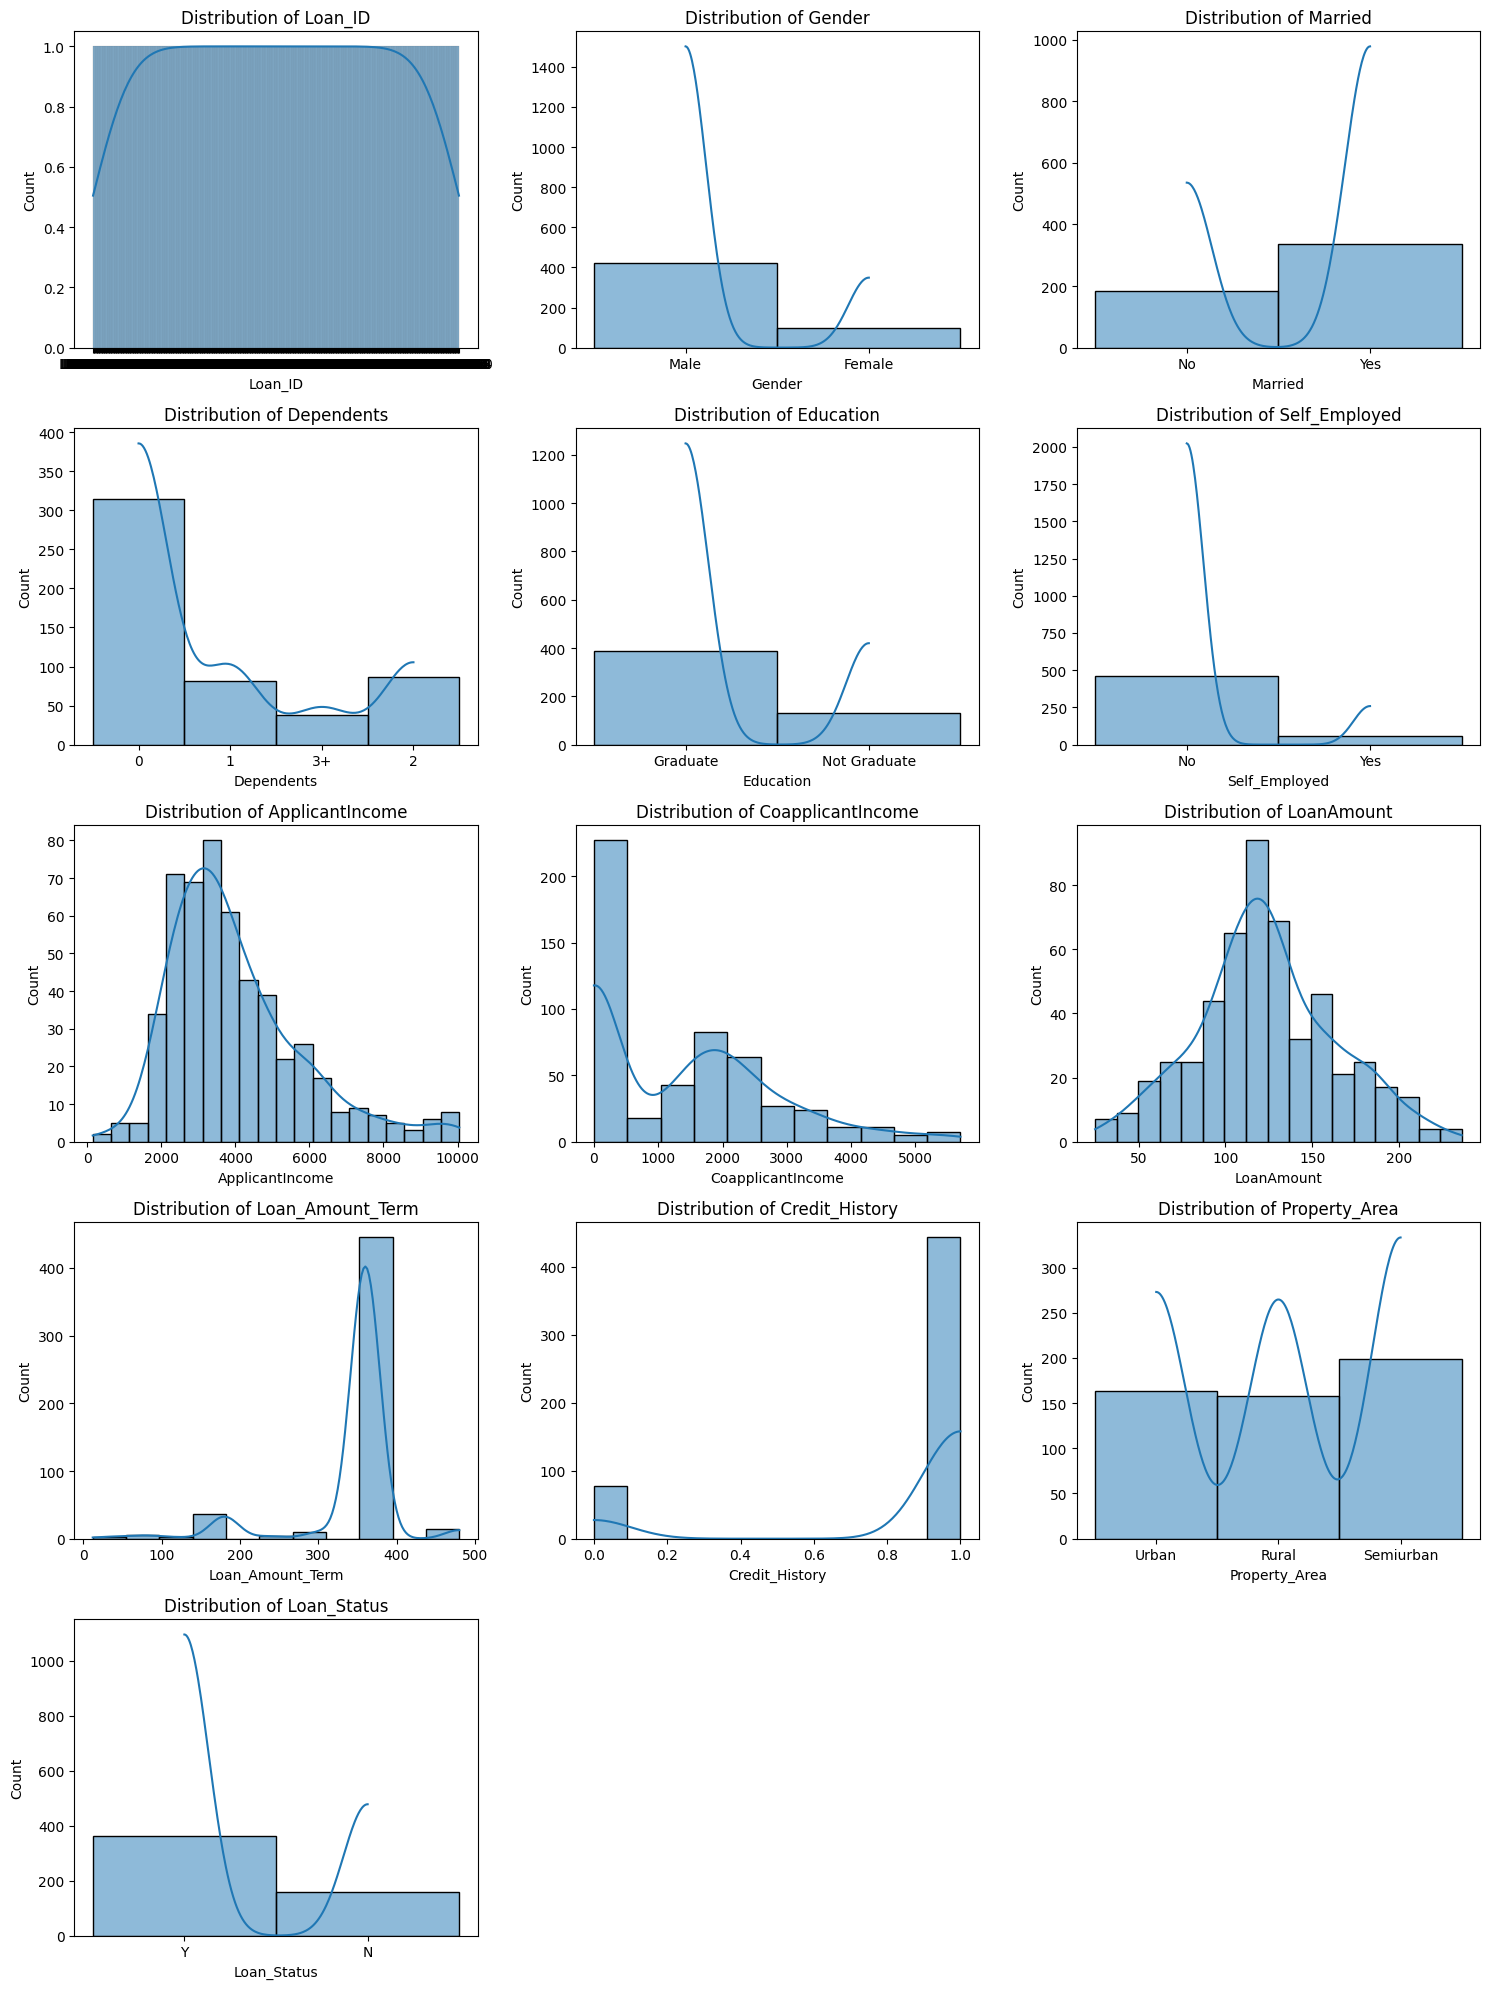

In [10]:
import math

# Number of charts per row
n_cols = 3

# Calculate required number of rows
n_rows = math.ceil(len(df.columns) / n_cols)

# Create subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# Plot each column on its subplot
for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].set_title(f"Distribution of {col}")

# Hide any unused axes (if columns not multiple of 3)
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [11]:
df_2 = df.drop(columns='Loan_ID')
df_2

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,120.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
608,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,1.0,Rural,Y
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [12]:
df_obj = df_2.select_dtypes("object")
df_obj

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,Urban,Y
1,Male,Yes,1,Graduate,No,Rural,N
2,Male,Yes,0,Graduate,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,Urban,Y
4,Male,No,0,Graduate,No,Urban,Y
...,...,...,...,...,...,...,...
608,Male,Yes,0,Graduate,No,Rural,Y
609,Female,No,0,Graduate,No,Rural,Y
610,Male,Yes,3+,Graduate,No,Rural,Y
612,Male,Yes,2,Graduate,No,Urban,Y


# Lable Encoder

In [13]:
# Split features and target
X = df_obj

# Lable Encoder
le = LabelEncoder()
x2 = X.apply(lambda col: le.fit_transform(col))

x2

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,1,0,0,0,0,2,1
1,1,1,1,0,0,0,0
2,1,1,0,0,1,2,1
3,1,1,0,1,0,2,1
4,1,0,0,0,0,2,1
...,...,...,...,...,...,...,...
608,1,1,0,0,0,0,1
609,0,0,0,0,0,0,1
610,1,1,3,0,0,0,1
612,1,1,2,0,0,2,1


In [14]:
df_num = df.select_dtypes("number")
df_num

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,0.0,120.0,360.0,1.0
1,4583,1508.0,128.0,360.0,1.0
2,3000,0.0,66.0,360.0,1.0
3,2583,2358.0,120.0,360.0,1.0
4,6000,0.0,141.0,360.0,1.0
...,...,...,...,...,...
608,3232,1950.0,108.0,360.0,1.0
609,2900,0.0,71.0,360.0,1.0
610,4106,0.0,40.0,180.0,1.0
612,7583,0.0,187.0,360.0,1.0


In [15]:
df_mod = x2.join(df_num)
df_mod

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,1,0,0,0,0,2,1,5849,0.0,120.0,360.0,1.0
1,1,1,1,0,0,0,0,4583,1508.0,128.0,360.0,1.0
2,1,1,0,0,1,2,1,3000,0.0,66.0,360.0,1.0
3,1,1,0,1,0,2,1,2583,2358.0,120.0,360.0,1.0
4,1,0,0,0,0,2,1,6000,0.0,141.0,360.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
608,1,1,0,0,0,0,1,3232,1950.0,108.0,360.0,1.0
609,0,0,0,0,0,0,1,2900,0.0,71.0,360.0,1.0
610,1,1,3,0,0,0,1,4106,0.0,40.0,180.0,1.0
612,1,1,2,0,0,2,1,7583,0.0,187.0,360.0,1.0


In [16]:
loan_status = df_mod[['Loan_Status']]
df_mod = df_mod.drop(columns="Loan_Status", axis=0)
df_mod = df_mod.join(loan_status)
df_mod

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,1,0,0,0,0,2,5849,0.0,120.0,360.0,1.0,1
1,1,1,1,0,0,0,4583,1508.0,128.0,360.0,1.0,0
2,1,1,0,0,1,2,3000,0.0,66.0,360.0,1.0,1
3,1,1,0,1,0,2,2583,2358.0,120.0,360.0,1.0,1
4,1,0,0,0,0,2,6000,0.0,141.0,360.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
608,1,1,0,0,0,0,3232,1950.0,108.0,360.0,1.0,1
609,0,0,0,0,0,0,2900,0.0,71.0,360.0,1.0,1
610,1,1,3,0,0,0,4106,0.0,40.0,180.0,1.0,1
612,1,1,2,0,0,2,7583,0.0,187.0,360.0,1.0,1


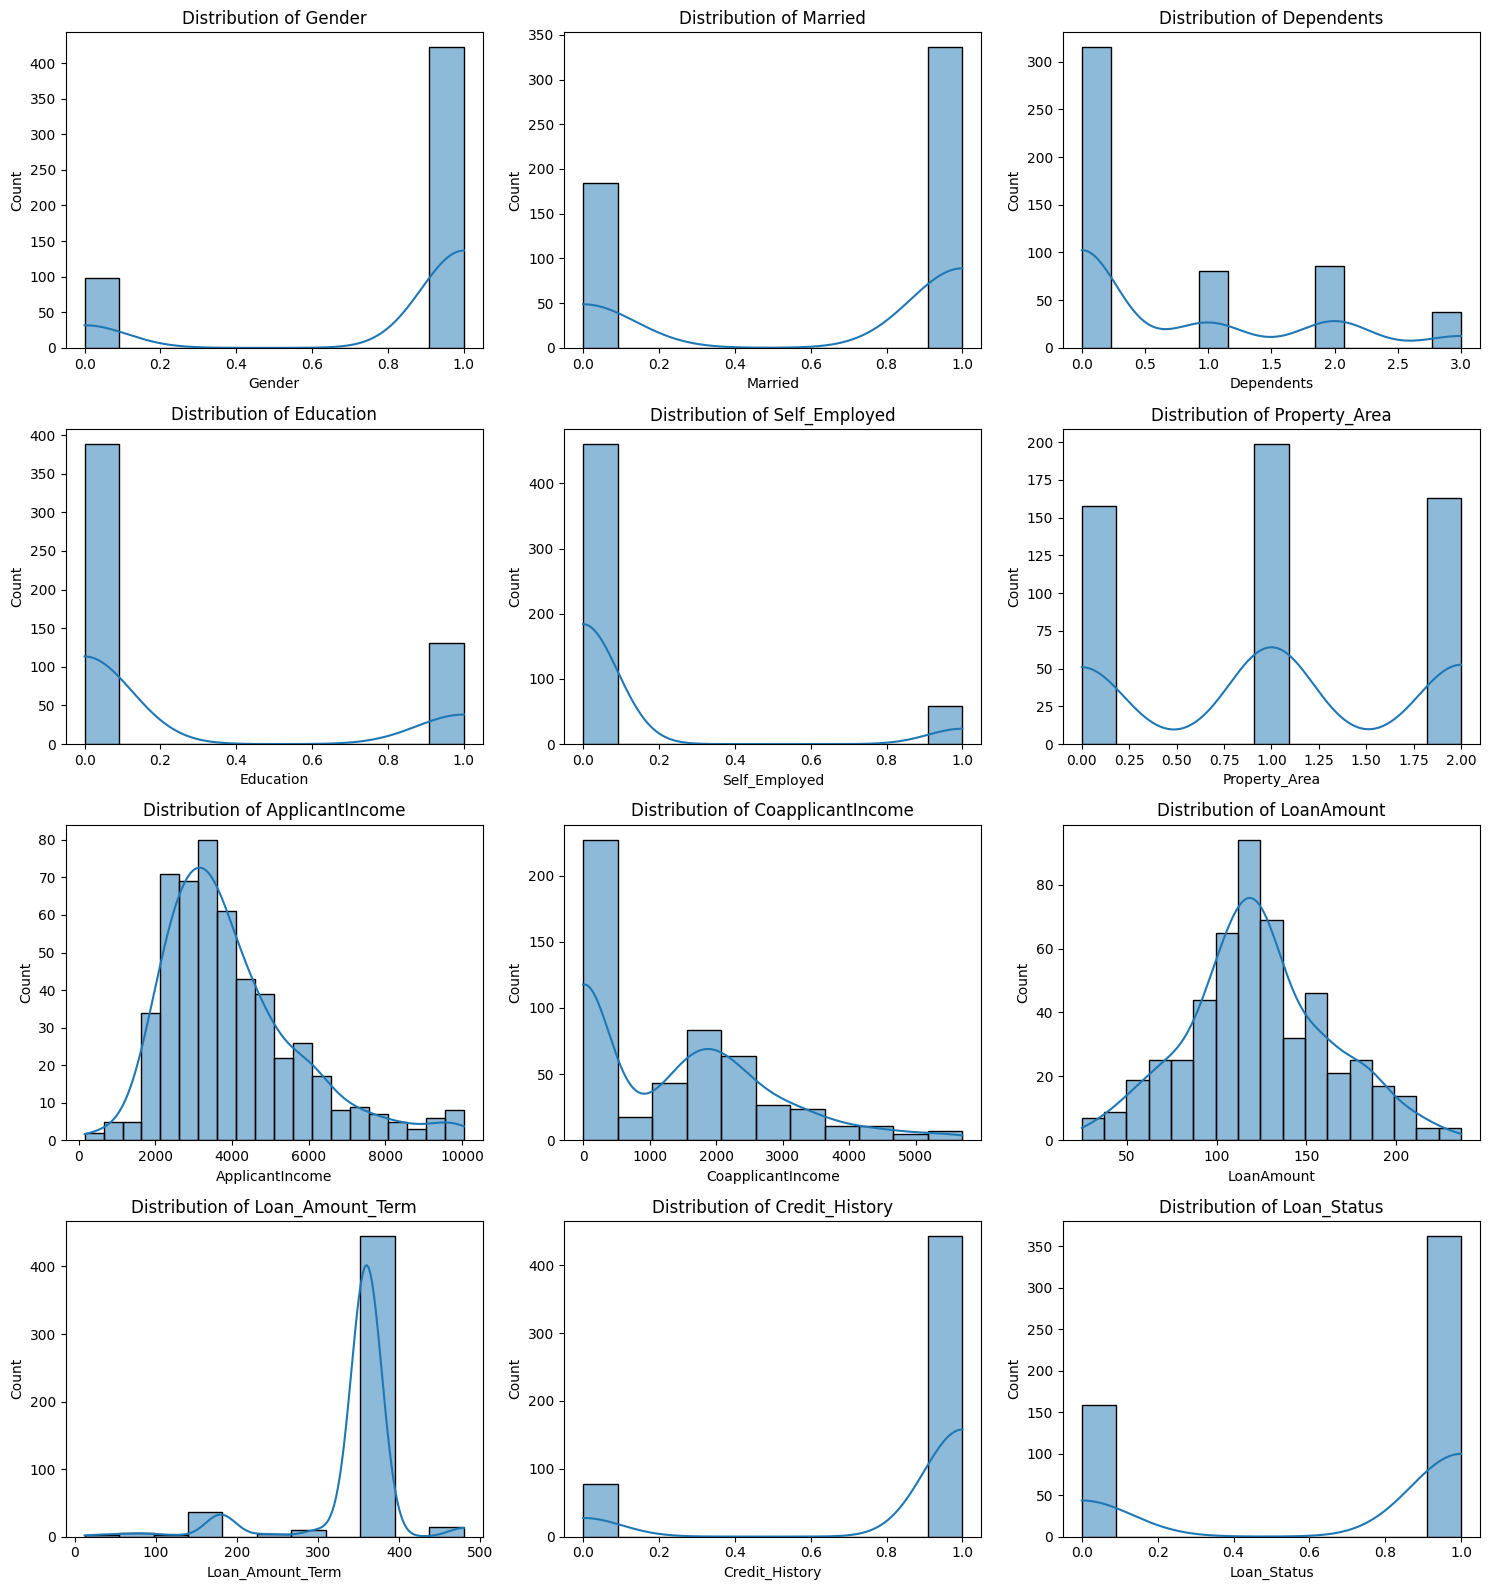

In [17]:
import math

# Number of charts per row
n_cols = 3

# Calculate required number of rows
n_rows = math.ceil(len(df_mod.columns) / n_cols)

# Create subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# Plot each column on its subplot
for i, col in enumerate(df_mod.columns):
    sns.histplot(df_mod[col], ax=axes[i], kde=True)
    axes[i].set_title(f"Distribution of {col}")

# Hide any unused axes (if columns not multiple of 3)
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [18]:
df_mod.describe()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,0.811538,0.646154,0.705769,0.251923,0.113462,1.009615,3995.719231,1317.578692,123.344231,342.576923,0.851923,0.696154
std,0.391457,0.478623,0.989329,0.434535,0.317462,0.786387,1794.687196,1397.402837,39.745999,65.618547,0.355518,0.460360
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,25.000000,12.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2724.500000,0.000000,100.000000,360.000000,1.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3590.500000,1293.500000,120.000000,360.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,4772.750000,2191.000000,150.000000,360.000000,1.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,2.000000,10047.000000,5701.000000,236.000000,480.000000,1.000000,1.000000


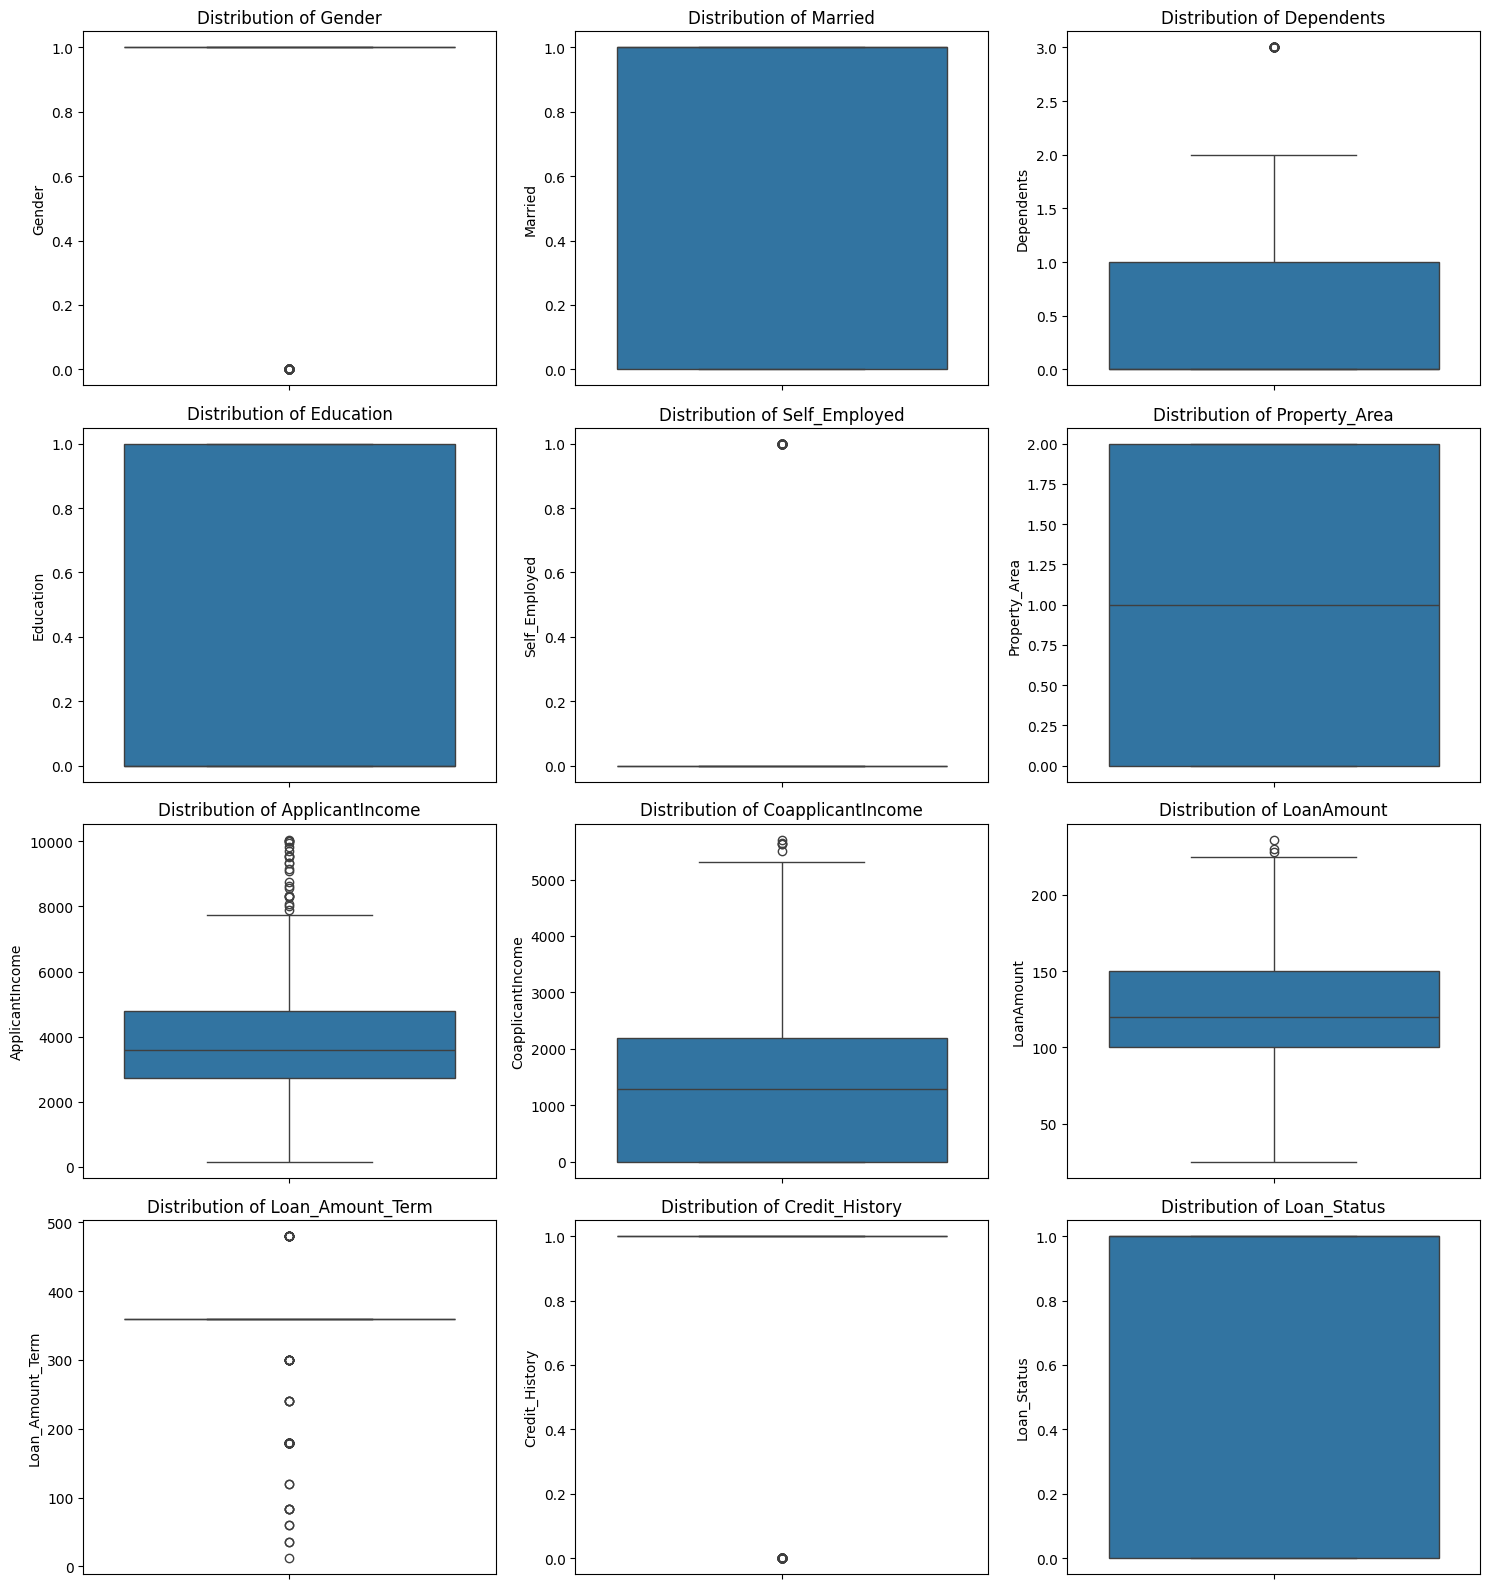

In [19]:
import math

# Number of charts per row
n_cols = 3

# Calculate required number of rows
n_rows = math.ceil(len(df_mod.columns) / n_cols)

# Create subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# Plot each column on its subplot
for i, col in enumerate(df_mod.columns):
    sns.boxplot(df_mod[col], ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

# Hide any unused axes (if columns not multiple of 3)
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Heat Map

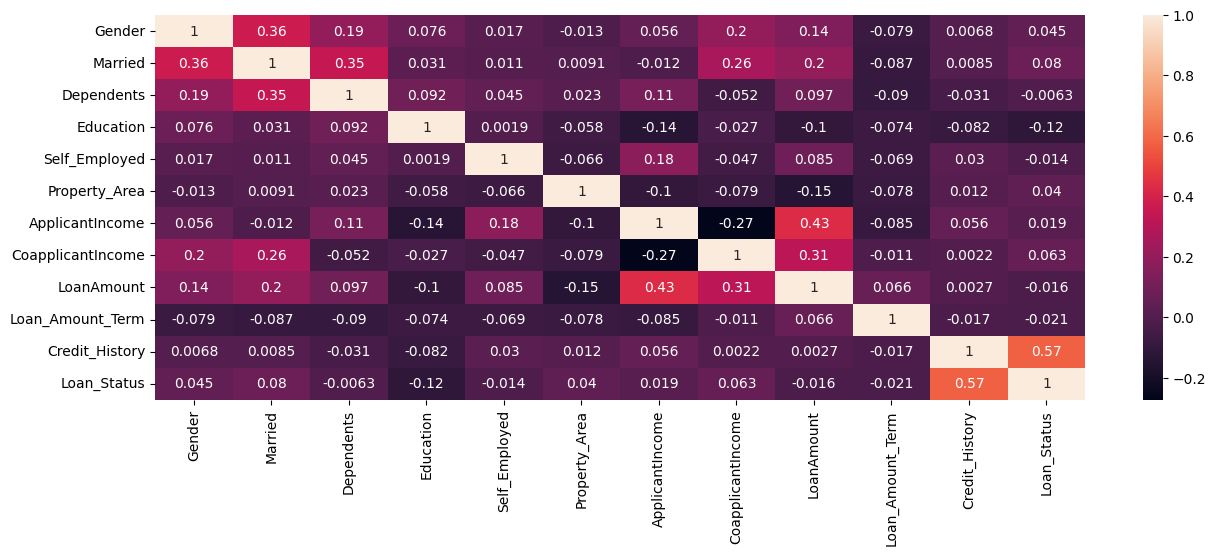

In [20]:
plt.figure(figsize=(15,5))
sns.heatmap(df_mod.corr(),annot=True)
plt.show()

# Feature Selection and Model Selection

In [21]:
df_mod.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status'],
      dtype='object')


 Running Forward Feature Selection...


100%|██████████| 11/11 [00:11<00:00,  1.02s/it]



 Running Backward Feature Selection...


100%|██████████| 11/11 [00:08<00:00,  1.37it/s]


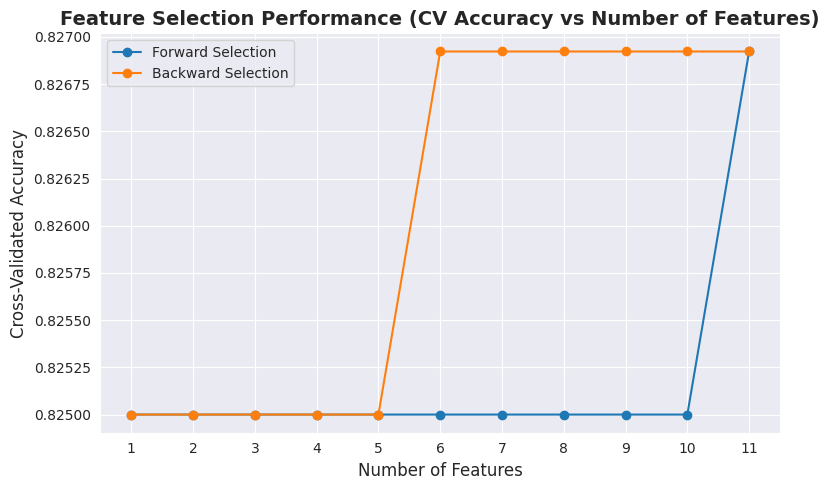


================ FEATURE SELECTION SUMMARY ================

Method: Forward
Best number of features: 11
Best features: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Best CV Accuracy: 0.8269
Runtime: 11.17 sec

Method: Backward
Best number of features: 6
Best features: ['Married', 'Education', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History']
Best CV Accuracy: 0.8269
Runtime: 8.06 sec

 Best Feature Selection Method: Forward
 Selected Best Features: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

===================== MODEL PERFORMANCE =====================
Logistic Regression: Accuracy = 0.8077
KNN: Accuracy = 0.6346
Decision Tree: Accuracy = 0.7500
Random Forest: Accuracy = 0.7885
Extra Trees: Accuracy = 0.76

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

from tqdm import tqdm

# ML models
from sklearn.linear_model import (
    LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    ExtraTreesClassifier, BaggingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Feature selection (SFS)
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold

# =============================
# DATA
# =============================
X = df_mod.iloc[:, :-1]
y = df_mod['Loan_Status']

# =============================
# SCALING
# =============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Logistic Regression for SFS
lr = LogisticRegression(max_iter=2000, solver='lbfgs', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
method_scores = {}

# =============================
# FEATURE SELECTION
# =============================
for method, forward_flag in [('Forward', True), ('Backward', False)]:
    print(f"\n Running {method} Feature Selection...")
    start_time = time.time()

    best_score = 0
    best_k = None
    best_features = None
    scores = []

    for k in tqdm(range(1, X.shape[1] + 1)):
        sfs = SequentialFeatureSelector(
            estimator=lr,
            k_features=k,
            forward=forward_flag,
            scoring='accuracy',
            cv=cv,
            n_jobs=-1
        )

        sfs.fit(X_scaled, y)
        scores.append(sfs.k_score_)

        if sfs.k_score_ > best_score:
            best_score = sfs.k_score_
            best_k = k
            best_features = sfs.k_feature_idx_

    elapsed = round(time.time() - start_time, 2)
    selected_cols = X.columns[list(best_features)]
    method_scores[method] = scores

    results.append({
        "Method": method,
        "Best number of features": best_k,
        "Best feature names": list(selected_cols),
        "Best cross-validated accuracy": best_score,
        "Runtime (s)": elapsed
    })

# =============================
# FEATURE SELECTION LINE PLOT
# =============================
plt.figure(figsize=(8,5))
for method, scores in method_scores.items():
    plt.plot(range(1, len(scores)+1), scores, marker='o', label=f"{method} Selection")

plt.title("Feature Selection Performance (CV Accuracy vs Number of Features)", fontsize=14, fontweight='bold')
plt.xlabel("Number of Features", fontsize=12)
plt.ylabel("Cross-Validated Accuracy", fontsize=12)
plt.xticks(range(1, X.shape[1]+1))
plt.legend()
plt.tight_layout()
plt.show()

# =============================
# SHOW RESULTS
# =============================
print("\n================ FEATURE SELECTION SUMMARY ================")
for r in results:
    print(f"\nMethod: {r['Method']}")
    print(f"Best number of features: {r['Best number of features']}")
    print(f"Best features: {r['Best feature names']}")
    print(f"Best CV Accuracy: {r['Best cross-validated accuracy']:.4f}")
    print(f"Runtime: {r['Runtime (s)']} sec")

# Pick best method overall
all_scores = [(r["Method"], r["Best cross-validated accuracy"]) for r in results]
best_method = max(all_scores, key=lambda x: x[1])[0]

best_features = results[0]["Best feature names"] if best_method == "Forward" else results[1]["Best feature names"]

print("\n Best Feature Selection Method:", best_method)
print(" Selected Best Features:", best_features)

# =============================
# TRAIN ALL CLASSIFICATION MODELS USING BEST FEATURES
# =============================
X_best = df_mod[best_features]
y_best = df_mod['Loan_Status']

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging": BaggingClassifier(),
    "SVC": SVC(),
    "Gaussian NB": GaussianNB(),
    "SGD Classifier": SGDClassifier(),
    "Passive Aggressive": PassiveAggressiveClassifier(),
    "MLP Neural Network": MLPClassifier(max_iter=2000)
}

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X_best, y_best, test_size=0.2, random_state=42
)

scores = {}

print("\n===================== MODEL PERFORMANCE =====================")
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        acc = accuracy_score(y_test, pred)
        scores[name] = acc
        print(f"{name}: Accuracy = {acc:.4f}")
    except:
        print(f"{name}: FAILED")

# Sort scores (descending)
sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)

print("\n===================== SORTED ACCURACY (DESC) =====================")
for name, score in sorted_scores:
    print(f"{name}: {score:.4f}")

best_model, best_score = sorted_scores[0]

print("\n BEST CLASSIFICATION MODEL =", best_model)
print(f" Accuracy = {best_score:.4f}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

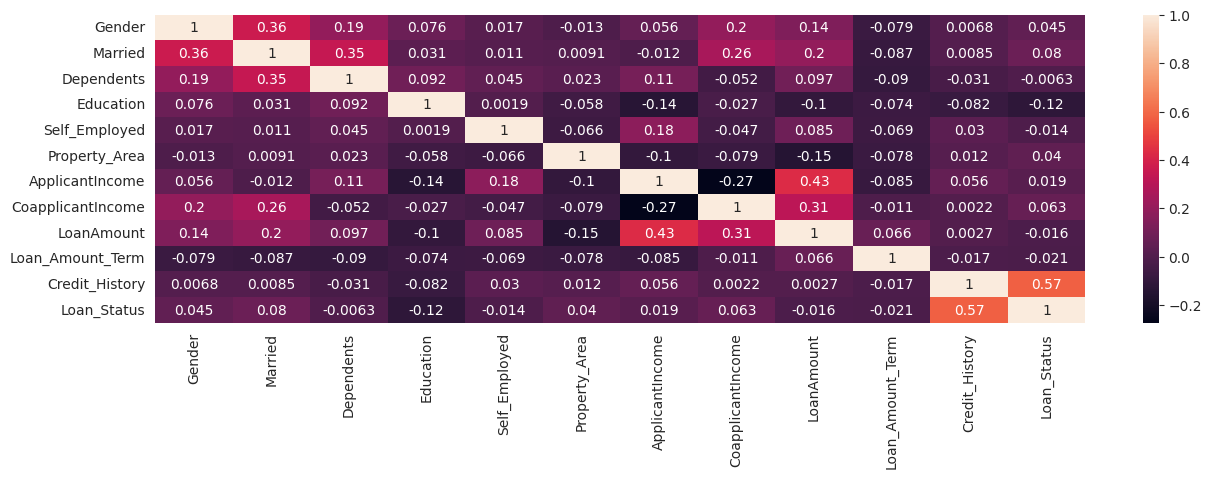

In [28]:
plt.figure(figsize=(15,4))
sns.heatmap(df_mod.corr(), annot=True)

plt.savefig("my_plot.png")
from google.colab import files
files.download("my_plot.png")

plt.show()


In [29]:
df_mod.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status'],
      dtype='object')

In [53]:
from sklearn.model_selection import train_test_split

x = df_mod.drop(columns='Loan_Status', axis=0)
y = df_mod['Loan_Status']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


***Linear Regression Model***

In [57]:
from sklearn.linear_model import LinearRegression
lr_model = LogisticRegression()

lr_model.fit(x_train, y_train)

print(f"Your model Acurency is: {(lr_model.score(x_train, y_train))*100:.4f}%")

Your model Acurency is: 83.4135%
